## PREPROCESSING
### Get the dataset
Load the dataset, split it in two for trainin and validation. As in the Reference model provided by [Lyft](https://level5.lyft.com/), a dataframe with one scene per row is created.

In [1]:
DATASET_VERSION = 'v1.02-train'
DATASET_ROOT = '../local_th/data/'

#The code will generate data, visualization and model checkpoints
ARTIFACTS_FOLDER = "./artifacts"

In [2]:
%load_ext autoreload

from datetime import datetime
from functools import partial
import glob
#Disabled for numpy and opencv: avod has opencv and numpy versions for several methods
from multiprocessing import Pool

import os
#os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pandas as pd
import cv2
import PIL
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import argparse
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix


In [3]:
gpus = tf.compat.v1.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4) 
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [4]:
level5data = LyftDataset(json_path=DATASET_ROOT + "/v1.02-train", data_path=DATASET_ROOT, verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
15991 instance,
8 sensor,
128 calibrated_sensor,
149072 ego_pose,
148 log,
148 scene,
18634 sample,
149072 sample_data,
539765 sample_annotation,
1 map,
Done loading in 4.8 seconds.
Reverse indexing ...
Done reverse indexing in 1.5 seconds.


## <font color="pink">TRAINING</font>
Based on the [AVOD algorithm](https://github.com/kujason/avod), we train the dataset. 
The goal is to study how the accuracy changes based on the type of sensors in input, and their number, thus changes to the AVOD algorithm have been made. Here we keep the two stage model.
Will be divided in steps, to mimick the divisions made by AVOD's authors in the code.

With respect to the original AVOD code, the following changes have been made:
<li> Upgrades for compatibity issues with tensorflow 2.0: migrated from slim libs to keras Sequential</li>
<li> Changes to support single type input </li>
<li> VGGs take as input Lyft-style dataset </li>



In [5]:
import avod
from avod.core import trainer

<b>RPN MODEL</b>: It is the fist subnetwork that makes up the double stage AVOD algorithm. It uses two VGGs, one for images, one for LiDar, to find the bottleneck.
Img VGG and Bev VGG have the same strucure, just have input from different sources. 

<b>VGG:</b> VGG is a convolutional neural network model. Here simplified model wrt K. Simonyan and A. Zisserman's model proposed in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
Basically, it lacks dense layers at the end, and the last group of conv layers is smaller that theirs.
Two VGGs, one for BEV, one for Images

In [6]:
import anchor_helper
from frame_helper import FrameCalibrationData
import frame_helper
import preproc_helper
import bev_helper

In [7]:
from PIL import Image
from avod.core import anchor_filter
from avod.core import anchor_projector
from avod.core import box_3d_encoder
from avod.core import constants
from avod.core import losses
from avod.core import model
from avod.core import summary_utils
from avod.core.anchor_generators import grid_anchor_3d_generator
from avod.datasets.kitti import kitti_aug
import avod.datasets.kitti.kitti_utils as kitti_utils
from avod.core.label_cluster_utils import LabelClusterUtils

In [8]:
class RpnModel(model.DetectionModel):
	##############################
	# Keys for Placeholders
	##############################
	PL_BEV_INPUT = 'bev_input_pl'
	PL_IMG_INPUT = 'img_input_pl'
	PL_ANCHORS = 'anchors_pl'

	PL_BEV_ANCHORS = 'bev_anchors_pl'
	PL_BEV_ANCHORS_NORM = 'bev_anchors_norm_pl'
	PL_IMG_ANCHORS = 'img_anchors_pl'
	PL_IMG_ANCHORS_NORM = 'img_anchors_norm_pl'
	PL_LABEL_ANCHORS = 'label_anchors_pl'
	PL_LABEL_BOXES_3D = 'label_boxes_3d_pl'
	PL_LABEL_CLASSES = 'label_classes_pl'

	PL_ANCHOR_IOUS = 'anchor_ious_pl'
	PL_ANCHOR_OFFSETS = 'anchor_offsets_pl'
	PL_ANCHOR_CLASSES = 'anchor_classes_pl'

	# Sample info, including keys for projection to image space
	# (e.g. camera matrix, image index, etc.)
	PL_CALIB_P2 = 'frame_calib_p2'
	PL_IMG_IDX = 'current_img_idx'
	PL_GROUND_PLANE = 'ground_plane'

	##############################
	# Keys for Predictions
	##############################
	PRED_ANCHORS = 'rpn_anchors'

	PRED_MB_OBJECTNESS_GT = 'rpn_mb_objectness_gt'
	PRED_MB_OFFSETS_GT = 'rpn_mb_offsets_gt'

	PRED_MB_MASK = 'rpn_mb_mask'
	PRED_MB_OBJECTNESS = 'rpn_mb_objectness'
	PRED_MB_OFFSETS = 'rpn_mb_offsets'

	PRED_TOP_INDICES = 'rpn_top_indices'
	PRED_TOP_ANCHORS = 'rpn_top_anchors'
	PRED_TOP_OBJECTNESS_SOFTMAX = 'rpn_top_objectness_softmax'

	##############################
	# Keys for Loss
	##############################
	LOSS_RPN_OBJECTNESS = 'rpn_objectness_loss'
	LOSS_RPN_REGRESSION = 'rpn_regression_loss'

	def __init__(self, model_config, pipeline_config, train_val_test, dataset):
		"""
		Args:
		    model_config: configuration for the model
		    train_val_test: "train", "val", or "test"
		    dataset: the dataset that will provide samples and ground truth
		"""

		# Sets model configs (_config)
		super(RpnModel, self).__init__(model_config)
		self.dataset=dataset
		self.pipeline_config = pipeline_config

		if train_val_test not in ["train", "val", "test"]:
			raise ValueError('Invalid train_val_test value,'
		                     'should be one of ["train", "val", "test"]')
		self._train_val_test = train_val_test

		self._is_training = (self._train_val_test == 'train')

		# Input config
		input_config = self._config.input_config
		self._bev_pixel_size = np.asarray([input_config.bev_dims_h, input_config.bev_dims_w])
		self._bev_depth = input_config.bev_depth
		self._img_pixel_size = np.asarray([input_config.img_dims_h, input_config.img_dims_w])
		self._img_depth = input_config.img_depth

		# Rpn config
		rpn_config = self._config.rpn_config
		self.proposal_roi_crop_size = 3*2  #3*2
		self._fusion_method = rpn_config.rpn_fusion_method
		if self._train_val_test in ["train", "val"]:
			self._nms_size = rpn_config.rpn_train_nms_size
		else:
			self._nms_size = rpn_config.rpn_test_nms_size

		self._nms_iou_thresh = rpn_config.rpn_nms_iou_thresh


		# Dataset
		classes=[]
		for i in self.dataset.category:
			classes.append(i.get("name"))
		self.classes = classes
		self.dataset = dataset
		self.dataset.train_val_test = self._train_val_test
		area_extents = self.pipeline_config.kitti_utils_config.area_extents
		self._area_extents = np.reshape(area_extents, (3, 2))
		self._bev_extents = self._area_extents[[0, 2]]

		label_cluster_utils = LabelClusterUtils(self.dataset)
		self._cluster_sizes, self._all_std = label_cluster_utils.get_clusters(5, self.dataset)

		anchor_strides = self.pipeline_config.kitti_utils_config.anchor_strides
		self._anchor_strides= np.reshape(anchor_strides, (-1, 2))
		self._anchor_generator = grid_anchor_3d_generator.GridAnchor3dGenerator()

		self._path_drop_probabilities = self._config.path_drop_probabilities
		self._train_on_all_samples = self._config.train_on_all_samples
		self._eval_all_samples = self._config.eval_all_samples

		# Inputs-initialize empty, call method to fill. 
		self.img_input=[]
		self.bev_input=[]

		# Anchors
		self._anchors=[]
		self._anchor_offsets=[]
		self._anchor_ious=[]
		self._anchor_classes=[]
		self._bev_anchors=[]
		self._img_anchors=[]
		self._bev_anchors_norm=[]
		self._img_anchors_norm=[]

		# Labels
		self._label_anchors=[]
		self._label_classes=[]
		self._label_boxes_3d=[]

		# Other stuff
		self._sample_name=[]
		self._calib=[]
		self._ground_plane=[]
        

		if self._train_val_test in ["val", "test"]:
		# Disable path-drop, this should already be disabled inside the
		# evaluator, but just in case.
			self._path_drop_probabilities[0] = 1.0
			self._path_drop_probabilities[1] = 1.0


	def build(self):
		
		self.feed_input(5)
		
		# Setup feature extractors: two models, one for each kind of input
		weight_decay=0.0005
		#shape due to shape provided by dataset. BEV could not be adapted: too sparse.

		print("\nStarting with the extractors..\n")
		bev_input=np.asarray(self.bev_input)
		img_input=np.asarray(self.img_input)

		inputs_img = tf.keras.layers.Input(batch_shape=(None,300,200,3))
		net = tf.keras.layers.Conv2D(filters = 32, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
						kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), use_bias=False, padding='same', name="conv1")(inputs_img)
		net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch1")(net)
		net = tf.keras.layers.Conv2D(filters = 32, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	        				kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv2")(net)
		net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch2")(net)

		net = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool1")(net)

		net = tf.keras.layers.Conv2D(filters = 64, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
	                                        use_bias=False, padding='same', name="conv3")(net)
		net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch3")(net)
		net = tf.keras.layers.Conv2D(filters = 64, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
	                                        use_bias=False, padding='same', name="conv4")(net)
		net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch4")(net)

		net = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool2")(net)

		net = tf.keras.layers.Conv2D(filters = 128,kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv5")(net)
		net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch5")(net)
		net = tf.keras.layers.Conv2D(filters = 128, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv6")(net)
		net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch6")(net)
		net = tf.keras.layers.Conv2D(filters = 128, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv7")(net)
		net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch7")(net)

		net = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool3")(net)

		net = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv8") (net)
		net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch8")(net)
		net = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv9")(net)
		net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch9")(net)
		net = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv10")(net)
		net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch10")(net)
	        
		img_vgg = tf.keras.models.Model(inputs = inputs_img, outputs = net, name="img_vgg")
		img_vgg.summary()
	        
		self.img_bottleneck = tf.keras.layers.Conv2D(filters = 32, kernel_size = [1,1], strides =(1,1), padding='same', name="bottleneck")(net)
		self.img_bottleneck= tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros',\
	                                            gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones',\
	                                            beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(self.img_bottleneck)
		img_features = img_vgg.predict(img_input)
		#print(tf.shape(img_features), tf.shape(img_input), tf.shape(self.img_bottleneck))
	         #shape due to shape provided by dataset. BEV could not be adapted: too sparse.
	        
		inputs_bev = tf.keras.layers.Input(batch_shape=(None,336,336,3))
		out = tf.keras.layers.Conv2D(filters = 32, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(),\
	                                        activation=tf.nn.relu, kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	        				use_bias=False, padding='same', name="conv1")(inputs_bev)
		out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch1")(out)
		out = tf.keras.layers.Conv2D(filters = 32, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv2")(out)
		out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch2")(out)

		out = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool1")(out)


		out = tf.keras.layers.Conv2D(filters = 64, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv3")(out)
		out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch3")(out)
		out = tf.keras.layers.Conv2D(filters = 64, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv4")(out)
		out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch4")(out)

		out = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool2")(out)

		out = tf.keras.layers.Conv2D(filters = 128,kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv5")(out)
		out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch5")(out)
		out = tf.keras.layers.Conv2D(filters = 128, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
	                                        use_bias=False, padding='same', name="conv6")(out)
		out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch6")(out)
		out = tf.keras.layers.Conv2D(filters = 128, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv7")(out)
		out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch7")(out)

		out = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool3")(out)

		out = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv8") (out)
		out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch8")(out)
		out = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv9")(out)
		out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
	                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch9")(out)
		out = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,\
	                                        kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),\
	                                        use_bias=False, padding='same', name="conv10")(out)
		out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',\
                                                moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,\
	                                        beta_constraint=None, gamma_constraint=None, name="batch10")(out)
	        
		bev_vgg = tf.keras.models.Model(inputs = inputs_bev, outputs = out, name="bev_vgg")
		bev_features=bev_vgg.predict(bev_input)
		
		bev_proposal_input = bev_features
		img_proposal_input = img_features
		print(img_proposal_input)

		fusion_mean_div_factor = 2.0
		print("\nFINISHED FEATURE EXTRACTION\n")

		# Select what to keep btw imgs and bev
		if not (self._path_drop_probabilities[0] == self._path_drop_probabilities[1] == 1.0):
			with tf.compat.v1.variable_scope('rpn_path_drop'):

				random_values = tf.random_uniform(shape=[3], minval=0.0, maxval=1.0)
				img_mask, bev_mask = self.create_path_drop_masks(self._path_drop_probabilities[0], self._path_drop_probabilities[1], random_values)
				img_proposal_input = tf.multiply(img_proposal_input, img_mask)
				bev_proposal_input = tf.multiply(bev_proposal_input, bev_mask)
				self.img_path_drop_mask = img_mask
				self.bev_path_drop_mask = bev_mask

				# Overwrite the division factor
				fusion_mean_div_factor = img_mask + bev_mask
		print("\nStarting ROI pooling..\n")

		with tf.compat.v1.variable_scope('proposal_roi_pooling'):

			with tf.compat.v1.variable_scope('box_indices'):
				def get_box_indices(boxes):
					proposals_shape = boxes.get_shape().as_list()
					if any(dim is None for dim in proposals_shape):
						proposals_shape = tf.shape(boxes)
					ones_mat = tf.ones(proposals_shape[:2], dtype=tf.int32)
					multiplier = tf.expand_dims(tf.range(start=0, limit=proposals_shape[0]), 1)
					multiplier=tf.squeeze(multiplier)
					#return tf.reshape(ones_mat * multiplier, [-1]),
					return multiplier

				print(self._bev_anchors_norm[5].shape)
				boxes_bev=tf.squeeze(self._bev_anchors_norm[0])

				tf_box_indices = get_box_indices(boxes_bev)
				print(self._bev_anchors_norm[0])
				print(self._img_anchors_norm[0])

			proposal_roi_size_tf = [3,3]
			# Do ROI Pooling on BEV eager ex on _bev_anchor
			#bev_proposal_rois = tf.image.crop_and_resize(bev_proposal_input,
		                                                 #boxes_bev, tf_box_indices, proposal_roi_size_tf)
			# Do ROI Pooling on image

			boxes_img=tf.squeeze(self._img_anchors_norm[0])
			indices=get_box_indices(boxes_img)

			img_proposal_rois = tf.image.crop_and_resize(img_proposal_input, boxes_img, indices, proposal_roi_size_tf)

			#verify if one is correct
			fig=plt.figure(figsize=(300,200))
			raw=fig.add_subplot(1,2,1)
			raw.imshow(img_proposal_rois[0,:,:, 0], cmap="hot")
			plt.show()


		with tf.compat.v1.variable_scope('proposal_roi_fusion'):
			rpn_fusion_out = None
			if self._fusion_method == 'mean':
				tf_features_sum = tf.add(bev_proposal_rois, img_proposal_rois)
				rpn_fusion_out = tf.divide(tf_features_sum, 2)
			elif self._fusion_method == 'concat':
				rpn_fusion_out = tf.concat([bev_proposal_rois, img_proposal_rois], axis=3)
			else:
				raise ValueError('Invalid fusion method', self._fusion_method)

		with tf.compat.v1.variable_scope('anchor_predictor', 'ap', [rpn_fusion_out]):
		    
			print("here", tf_features_sum)
			# Rpn layers config
			weight_decay = 0.005

			tensor_in = tf.keras.Input(shape=None, tensor=rpn_fusion_out)

			# Use conv2d instead of fully_connected layers.
			cls_fc6 = tf.keras.layers.Conv2D(filters=32, kernel_size = [3,3], kernel_initializer='ones', 
			                                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='VALID', name="conv1")(tensor_in)
			cls_fc6_drop = tf.keras.layers.Dropout(rate = 0.5, name="drop1")(cls_fc6)
			cls_fc7 = tf.keras.layers.Conv2D(filters=32, kernel_size = [1,1], kernel_initializer='ones',
			                                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='VALID', name="conv2")(cls_fc6_drop)
			cls_fc7_drop = tf.keras.layers.Dropout(rate = 0.5, name="drop2")(cls_fc7)
			cls_fc8 = tf.keras.layers.Conv2D(filters=2, kernel_size = [1,1], kernel_initializer='ones',
			                                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='VALID', name="conv3")(cls_fc7_drop)
			objectness = tf.squeeze(cls_fc8, axis=[1,2], name='conv3/squeezed')

			obj_model = tf.keras.models.Model(inputs = rpn_fusion_out, outputs = objectness, name="objectness predictions")
			obj_model.summary()
			obj_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])
			prediction_obj = bev_vgg.fit(self.input_bev, batch_size=64, epochs=50, validation_split=0.2)

			# Use conv2d instead of fully_connected layers.
			reg_fc6 = tf.keras.layers.Conv2D(filters=32, kernel_size = [3,3], kernel_initializer="ones", 
			                        kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='VALID', name="conv4")(tensor_in)

			reg_fc6_drop = tf.keras.layers.Dropout(rate = 0.5, name="drop3")(reg_fc6)

			reg_fc7 = tf.keras.layers.Conv2D(filters = 16, kernel_size = [1, 1], kernel_initializer="ones",
			                        kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding="same", name="conv5")(reg_fc6_drop)

			reg_fc7_drop = tf.keras.layers.Dropout(rate = 0.5, name="drop4")(reg_fc7)

			reg_fc8 = tf.keras.layers.Conv2D(filters = 6,  kernel_size = [1, 1],  kernel_initializer="ones",
			                        kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding="same", name="conv6")(reg_fc7_drop)

			offsets = tf.squeeze(reg_fc8, axis=[1,2], name='conv6/squeezed')

			off_model = tf.keras.models.Model(inputs = rpn_fusion_out, outputs = offsets, name="rpn_fusion_prediction_anchors")
			off_model.summary()
			off_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])
			prediction_off = off_model.fit(self.input_bev, batch_size=64, epochs=50, validation_split=0.2)
		    
		    
		# Return the proposals
		with tf.compat.v1.variable_scope('proposals'):
		    #anchors = self.placeholders[self.PL_ANCHORS]
			anchors = self._anchors

		    # Decode anchor regression offsets
			with tf.compat.v1.variable_scope('decoding'):
				regressed_anchors = anchor_helper.offset_to_anchor(anchors, offsets)

			with tf.compat.v1.variable_scope('bev_projection'):
				 _, bev_proposal_boxes_norm = anchor_projector.project_to_bev(regressed_anchors, self._bev_extents)

			with tf.compat.v1.variable_scope('softmax'):
				objectness_softmax = tf.nn.softmax(objectness)

			with tf.compat.v1.variable_scope('nms'):
				objectness_scores = objectness_softmax[:, 1]

		        # Do NMS on regressed anchors
				top_indices = tf.image.non_max_suppression(
		            bev_proposal_boxes_norm, objectness_scores,
		            max_output_size=self._nms_size,
		            iou_threshold=self._nms_iou_thresh)

				top_anchors = tf.gather(regressed_anchors, top_indices)
				top_objectness_softmax = tf.gather(objectness_scores, top_indices)
				top_offsets = tf.gather(offsets, top_indices)
				top_objectness = tf.gather(objectness, top_indices)

		# Get mini batch #TODO eager execution 
		#all_ious_gt = self.placeholders[self.PL_ANCHOR_IOUS]
		#all_offsets_gt = self.placeholders[self.PL_ANCHOR_OFFSETS]
		#all_classes_gt = self.placeholders[self.PL_ANCHOR_CLASSES]
		all_offsets_gt =  self._anchor_offsets
		all_ious_gt = self._anchor_ios
		all_classes_gt = self._anchor_classes

		with tf.compat.v1.variable_scope('mini_batch'):
			mini_batch_mask, _ = anchor_helper.sample_mini_batch(all_ious_gt, 64,[0, 0.3], [0.5,1])

		# ROI summary images
		rpn_mini_batch_size = 64
		with tf.compat.v1.variable_scope('bev_rpn_rois'):
			mb_bev_anchors_norm = tf.boolean_mask(self._bev_anchors_norm, mini_batch_mask)
			mb_bev_box_indices = tf.zeros_like(tf.boolean_mask(all_classes_gt, mini_batch_mask), dtype=tf.int32)

			# Show the ROIs of the BEV input density map
			# for the mini batch anchors
			bev_input_rois = tf.image.crop_and_resize(self.bev_input, mb_bev_anchors_norm, mb_bev_box_indices, (32, 32))

			bev_input_roi_summary_images = tf.split(bev_input_rois, self._bev_depth, axis=3)
			tf.summary.image('bev_rpn_rois', bev_input_roi_summary_images[-1], max_outputs=rpn_mini_batch_size)

		with tf.compat.v1.variable_scope('img_rpn_rois'):
			# ROIs on image input TODO placeolder
			mb_img_anchors_norm = tf.boolean_mask(self._img_anchors_norm, mini_batch_mask)
			mb_img_box_indices = tf.zeros_like( tf.boolean_mask(all_classes_gt, mini_batch_mask), dtype=tf.int32)

			# Do test ROI pooling on mini batch
			img_input_rois = tf.image.crop_and_resize(self.img_input, mb_img_anchors_norm, mb_img_box_indices, (32, 32))
			tf.summary.image('img_rpn_rois', img_input_rois, max_outputs=rpn_mini_batch_size)

		# Ground Truth Tensors
		with tf.compat.v1.variable_scope('one_hot_classes'):

			# Anchor classification ground truth
			# Object / Not Object
			min_pos_iou = 0.5

			objectness_classes_gt = tf.cast(tf.greater_equal(all_ious_gt, min_pos_iou), dtype=tf.int32)
			objectness_gt = tf.one_hot(objectness_classes_gt, depth=2, on_value=1.0 - self._config.label_smoothing_epsilon,
		                               off_value=self._config.label_smoothing_epsilon)

		# Mask predictions for mini batch
		with tf.compat.v1.variable_scope('prediction_mini_batch'):
			objectness_masked = tf.boolean_mask(objectness, mini_batch_mask)
			offsets_masked = tf.boolean_mask(offsets, mini_batch_mask)

		with tf.compat.v1.variable_scope('ground_truth_mini_batch'):
			objectness_gt_masked = tf.boolean_mask(objectness_gt, mini_batch_mask)
			offsets_gt_masked = tf.boolean_mask(all_offsets_gt, mini_batch_mask)

		# Specify the tensors to evaluate
		predictions = dict()

		predictions[self.PRED_TOP_OBJECTNESS_SOFTMAX] = top_objectness_softmax


	def feed_input(self, scene_index=None):
		"""Fills in the placeholders with the actual input values.
			Currently, only a scene is supported

		Args:
			scene_idx: TODO
		Returns:
			a feed_dict dictionary that can be used in a tensorflow session
		"""
		#TODO: read scenes up to scene_idx: modify preproc scipt accordingly

		if scene_index is not None:
			my_scene = self.dataset.scene[scene_index]
		else:
			raise TypeError('for testing you need to put a number! will change it later on once it works fully :) ')

		#general data.
	    
		voxel_size = (0.4,0.4,1.5)
		z_offset = -2.0
		#arbitrary shape, must be square though!
		bev_shape = (336,336, 3)
	    
		# Only handle one sample at a time for now
		my_sample_token = my_scene["first_sample_token"]
		last_sample_token = my_scene["last_sample_token"]

		while my_sample_token!=last_sample_token:

			# We only need orientation from box_3
			sample = self.dataset.get('sample', my_sample_token)
			sample_name = sample.get("token")
			anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(sample_name, self.classes, self.dataset)

			# Network input data: loop to get batch info
			img_input = self.dataset.get('sample_data', sample['data']["CAM_FRONT"])
			img_data=img_input
			camera_token=img_input.get("token")
			file_name=self.dataset.get_sample_data_path(camera_token)
			image = Image.open(file_name)
			image = image.resize((306,256), Image.ANTIALIAS)
			# convert image to numpy array
			img_array = np.asarray(image)
			self.img_input.append(img_array)
			# Image shape (h, w), fixed, dunno if need to save
			image_shape = [306, 256]

			bev_input = self.dataset.get('sample_data', sample['data']["LIDAR_TOP"])
			bev_data = bev_input
			bev_token= bev_input.get("token")
			lidar_data = self.dataset.get("sample_data", bev_token)
			lidar_filepath = self.dataset.get_sample_data_path(bev_token)
			ego_pose = self.dataset.get("ego_pose", lidar_data["ego_pose_token"])
			calibrated_sensor_lidar = self.dataset.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
			global_from_car = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation']), inverse=False)
			car_from_sensor_lidar = transform_matrix(calibrated_sensor_lidar['translation'], Quaternion(calibrated_sensor_lidar['rotation']),
			                                          inverse=False)
			lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
			lidar_pointcloud.transform(car_from_sensor_lidar)
			map_mask = level5data.map[0]["mask"]
			bev = bev_helper.create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
			#ego_centric_map = bev_helper.get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=voxel_size, output_shape=(336,336)) 
			bev_array = bev_helper.normalize_voxel_intensities(bev)
			self.bev_input.append(bev_array)

			#ground plane shape (a,b,c,d) in kitti:
			#no info on ground plane in nuscenes data, just global coordinate system
			#which is given as x, y, z. Computed from the cameras position:
			#suppose as in kitti that ground plane is as the same level with the cameras

			cam_front_token = self.dataset.get('sample_data', sample['data']["CAM_FRONT"])
			cam_front_data = cam_front_token.get("calibrated_sensor_token")
			cam_front_calib = self.dataset.get("calibrated_sensor", cam_front_data )
			cam_front_coords = cam_front_calib.get("translation")

			cam_front_left_token = self.dataset.get('sample_data', sample['data']["CAM_FRONT_LEFT"])
			cam_front_left_data = cam_front_left_token.get("calibrated_sensor_token")
			cam_front_left_calib = self.dataset.get("calibrated_sensor", cam_front_left_data )
			cam_front_left_coords = cam_front_left_calib.get("translation")

			cam_front_right_token = self.dataset.get('sample_data', sample['data']["CAM_FRONT_RIGHT"])
			cam_front_right_data = cam_front_right_token.get("calibrated_sensor_token")
			cam_front_right_calib = self.dataset.get("calibrated_sensor", cam_front_right_data )
			cam_front_right_coords = cam_front_right_calib.get("translation")

			ground_plane = frame_helper.get_ground_plane_coeff(cam_front_coords, cam_front_left_coords, cam_front_right_coords)

			#only for cameras, of course lidars do not have instrinsic matrices
			token=img_data.get("calibrated_sensor_token") 
			stereo_calib_p2 = frame_helper.read_calibration(token, self.dataset)

			#get next sample to extract info
			my_sample_token = self.dataset.get("sample", my_sample_token)["next"]

			# Fill the placeholders for anchor information
			self._fill_inputs(anchors_info=anchors_info,sample_token=bev_token, ground_plane=ground_plane,
			                            image_shape=image_shape, stereo_calib_p2=stereo_calib_p2,
			                            sample_name=sample_name)

			self._label_anchors.append(label_anchors)
			self._label_boxes_3d.append(label_boxes_3d)
			self._label_classes.append(label_classes)

			self._sample_name.append(str(sample_name))
			self._calib.append(stereo_calib_p2)
			self._ground_plane.append(ground_plane)

		return self.img_input

	def _fill_inputs(self,
			sample_token,
			anchors_info,
			ground_plane,
			image_shape,
			stereo_calib_p2,
			sample_name):
		"""
		Fills anchor placeholder inputs with corresponding data

		Args:
		    anchors_info: anchor info from mini_batch_utils
		    ground_plane: ground plane coefficients
		    image_shape: image shape (h, w), used for projecting anchors
		    sample_name: name of the sample, e.g. "000001"
		"""

		# Lists for merging anchors info
		all_anchor_boxes_3d = []
		anchors_ious = []
		anchor_offsets = []
		anchor_classes = []

		# Create anchors for each class
		if len(self.classes) > 1:
			for class_idx in range(len(self.classes)):
				cluster_sizes = []
				for i in self._cluster_sizes[class_idx]:
					if i!=[]:
						cluster_sizes.append(i)
				if len(cluster_sizes)!=0:
				# Generate anchors for all classes
					grid_anchor_boxes_3d = self._anchor_generator.generate(
						area_3d=self._area_extents,
						anchor_3d_sizes=cluster_sizes,
						anchor_stride=self._anchor_strides[0],
						ground_plane=ground_plane)
				else:
					#no labels per class, no anchor per class
					grid_anchor_boxes_3d=[]
				all_anchor_boxes_3d.append(grid_anchor_boxes_3d)

			all_anchor_boxes_3d = np.concatenate(all_anchor_boxes_3d, axis=None)
		else:
			# Don't loop for a single class
			class_idx = 0
			cluster_sizes[class_idx] = [x for x in self._cluster_sizes[class_idx] if x != []]
			if self._cluster_sizes[class_idx]!=[]:
				grid_anchor_boxes_3d = self._anchor_generator.generate(area_3d=self._area_extents, anchor_3d_sizes=cluster_sizes[class_idx], 
		                                                               anchor_stride=self._anchor_strides[0], ground_plane=ground_plane)
				all_anchor_boxes_3d = grid_anchor_boxes_3d

		# Filter empty anchors
		# Skip if anchors_info is []
		sample_has_labels = True

		# Convert lists to ndarrays
		#already filtered them before
		anchor_boxes_3d_to_use = all_anchor_boxes_3d
		anchors_ious = np.asarray(anchors_ious)
		anchor_offsets = np.asarray(anchor_offsets)
		anchor_classes = np.asarray(anchor_classes)

		# Flip anchors and centroid x offsets for augmented samples
		#             if kitti_aug.AUG_FLIPPING in sample_augs:
		#                 anchor_boxes_3d_to_use = kitti_aug.flip_boxes_3d(anchor_boxes_3d_to_use, flip_ry=False)
		#                 if anchors_info:
		#                     anchor_offsets[:, 0] = -anchor_offsets[:, 0]

		# Convert to anchors
		anchors_to_use = box_3d_encoder.box_3d_to_anchor(anchor_boxes_3d_to_use)
		num_anchors = len(anchors_to_use)

		# Project anchors into bev
		bev_anchors, bev_anchors_norm = anchor_projector.project_to_bev( anchors_to_use, [[-168,168], [-168,168 ]])


		# Project box_3d anchors into image space
		img_anchors, img_anchors_norm = anchor_projector.project_to_image_space(anchors_to_use, stereo_calib_p2, image_shape)

		# Reorder into [y1, x1, y2, x2] for tf.crop_and_resize op
		self._bev_anchors_norm.append(bev_anchors_norm[:, [1, 0, 3, 2]])
		self._img_anchors_norm.append(img_anchors_norm[:, [1, 0, 3, 2]])

		# Fill in placeholder inputs
		self._anchors.append(anchors_to_use)

		# If we are in train/validation mode, and the anchor infos
		# are not empty, store them. Checking for just anchors_ious
		# to be non-empty should be enough.
		if self._train_val_test in ['train', 'val'] and len(anchors_ious) > 0:
			self._anchor_ious.append(anchors_ious)
			self._anchor_offsets.append(anchor_offsets)
			self._anchor_classes.append(anchor_classes)

		# During test, or val when there is no anchor info
		elif self._train_val_test in ['test'] or len(anchors_ious) == 0:
			# During testing, or validation with no gt, fill these in with 0s
			#             self._placeholder_inputs[self.PL_ANCHOR_IOUS] = np.zeros(num_anchors)
			#             self._placeholder_inputs[self.PL_ANCHOR_OFFSETS] = np.zeros([num_anchors, 6])
			#             self._placeholder_inputs[self.PL_ANCHOR_CLASSES] = np.zeros(num_anchors)
			self._anchor_ious.append(anchors_ious)
			self._anchor_offsets.append(anchor_offsets)
			self._anchor_classes.append(anchor_classes)
		                                              
		else:
			raise ValueError('Got run mode {}, and non-empty anchor info'.format(self._train_val_test))

		self._bev_anchors = bev_anchors
		self._img_anchors = img_anchors
                                                      

	def create_path_drop_masks(self,
								p_img,
								p_bev,
								random_values):
		"""Determines global path drop decision based on given probabilities.

		Args:
		p_img: A tensor of float32, probability of keeping image branch
		p_bev: A tensor of float32, probability of keeping bev branch
		random_values: A tensor of float32 of shape [3], the results
		    of coin flips, values should range from 0.0 - 1.0.

		Returns:
		final_img_mask: A constant tensor mask containing either one or zero
		    depending on the final coin flip probability.
		final_bev_mask: A constant tensor mask containing either one or zero
		    depending on the final coin flip probability.
		"""

		def keep_branch(): return tf.constant(1.0)

		def kill_branch(): return tf.constant(0.0)

		# The logic works as follows:
		# We have flipped 3 coins, first determines the chance of keeping
		# the image branch, second determines keeping bev branch, the third
		# makes the final decision in the case where both branches were killed
		# off, otherwise the initial img and bev chances are kept.

		img_chances = tf.case([(tf.less(random_values[0], p_img), keep_branch)], default=kill_branch)

		bev_chances = tf.case([(tf.less(random_values[1], p_bev), keep_branch)], default=kill_branch)

		# Decision to determine whether both branches were killed off
		third_flip = tf.logical_or(tf.cast(img_chances, dtype=tf.bool), tf.cast(bev_chances, dtype=tf.bool))
		third_flip = tf.cast(third_flip, dtype=tf.float32)

		# Make a second choice, for the third case
		# Here we use a 50/50 chance to keep either image or bev
		# If its greater than 0.5, keep the image
		img_second_flip = tf.case([(tf.greater(random_values[2], 0.5), keep_branch)], default=kill_branch)
		# If its less than or equal to 0.5, keep bev
		bev_second_flip = tf.case([(tf.less_equal(random_values[2], 0.5), keep_branch)],
		                          default=kill_branch)

		# Use lambda since this returns another condition and it needs to
		# be callable
		final_img_mask = tf.case([(tf.equal(third_flip, 1), lambda: img_chances)], default=lambda: img_second_flip)

		final_bev_mask = tf.case([(tf.equal(third_flip, 1), lambda: bev_chances)], default=lambda: bev_second_flip)

		return final_img_mask, final_bev_mask

## Test this part!!

Tests and results for the RPN model part. The following changes to the model were done after errors/issues with testing:
<li>Maybe change the use of placeholders in the future, to fit with eager execution (shorter code)</li>
<li>Some internal keras os function rises a warning, something will be depreated, doesn't tell where and what function exactly</li>

In [9]:
import avod.builders.config_builder_util as config_build
config_path = 'avod/configs/unittest_model.config'
pipe_path = 'avod/configs/unittest_pipeline.config'
model_config = config_build.get_model_config_from_file(config_path)
pipeline_config=config_build.get_configs_from_pipeline_file(pipe_path, "val")
#rpn_model = RpnModel(model_config, pipeline_config[3],
 #                         train_val_test="val",
   #                       dataset=level5data)
# array=rpn_model.feed_input(5)
#predictions = rpn_model.build()
#tensor=tf.convert_to_tensor(array)


<b> AVOD MODEL: </b> second stage detector for the AVOD algorithm. It uses FPN as feature extractors.
<b> FPN: </b> Feature Pyramid Network (FPN) is a feature extractor designed for such pyramid concept with accuracy and speed in mind. It replaces the feature extractor of detectors like Faster R-CNN and generates multiple feature map layers (multi-scale feature maps) with better quality information than the regular feature pyramid for object detection. [Understanding Feature Pyramid Networks for object detection (FPN)](https://medium.com/@jonathan_hui/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c)

In [10]:
dataset=level5data
my_scene = dataset.scene[5]

        
voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
#arbitrary shape, must be square though!
bev_shape = (336,336, 3)
        
# Only handle one sample at a time for now
my_sample_token = my_scene["first_sample_token"]
my_last_sample_token = my_scene["last_sample_token"]
sample = dataset.get('sample', my_sample_token)
tok=sample['data']["CAM_FRONT"]
tok_bev=sample['data']["LIDAR_TOP"]
iboxes=dataset.get_boxes(tok)   
bboxes=dataset.get_boxes(tok_bev)
data_path, boxes, camera_intrinsic = dataset.get_sample_data(
                tok_bev)
data_path, uboxes, camera_intrinsic = dataset.get_sample_data(
                tok)
x=iboxes[0].wlh
v=bboxes[0].center
y=iboxes[0].corners(0.3)

classes=[]
for i in dataset.category:
    classes.append(i.get("name"))

print(iboxes[0].corners(),"\n", uboxes[0].corners())
#anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(tok, classes, dataset)

[[ 819.49527796  819.05221429  819.05221429  819.49527796  815.15305765
   814.70999398  814.70999398  815.15305765]
 [2576.23234062 2574.60352553 2574.60352553 2576.23234062 2577.41349377
  2575.78467869 2575.78467869 2577.41349377]
 [ -20.12505666  -20.12505666  -21.69905666  -21.69905666  -20.12505666
   -20.12505666  -21.69905666  -21.69905666]] 
 [[-1.02538412e+00  6.61964032e-01  7.02628232e-01 -9.84719920e-01
  -9.79330333e-01  7.08017819e-01  7.48682018e-01 -9.38666134e-01]
 [ 5.41679090e-02  1.07580054e-02  1.58413304e+00  1.62754295e+00
   2.34971948e-03 -4.10601841e-02  1.53231485e+00  1.57572476e+00]
 [ 1.16199462e+01  1.16377168e+01  1.16200132e+01  1.16022426e+01
   7.12048024e+00  7.13825084e+00  7.12054725e+00  7.10277665e+00]]


In [11]:
# Network input data: loop to get batch info
import box_helper
import bev_helper
import frame_helper
import preproc_helper
import io
from typing import Tuple, List

classes=[]
for i in dataset.category:
    classes.append(i.get("name"))

img_input_list=[]
img_target=[]
bev_input_list=[]
ground_plane_list=[]
lidar=[]

with tf.device('/GPU:0'):
    while my_sample_token!=my_last_sample_token:

        sample = dataset.get('sample', my_sample_token)
        sample_name = sample.get("token")
        img_data = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        camera_token=img_data.get("token")

        tok=sample['data']["CAM_FRONT"]
        boxes=dataset.get_boxes(tok) 

        ego_pose = dataset.get("ego_pose", img_data["ego_pose_token"])
        data_path, boxes, camera_intrinsic = dataset.get_sample_data(camera_token)
        data = Image.open(data_path)

        #anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(sample_name, classes, dataset)
    #     fig, ax = plt.subplots(1, 1, figsize=(9, 16))

    #     # Show image.
    #     ax.imshow(data)

    #     # Show boxes.
    #     for box in boxes:
    #         c = np.array(box_helper.get_color(box.name)) / 255.0
    #         box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))
    #     ax.axis('off')
    #     ax.set_title(img_data['channel'])
    #     ax.set_aspect('equal')

    #     # you can get a high-resolution image as numpy array!!
    #     plot_img_np = box_helper.get_img_from_fig(fig)


    #     # Limit visible range.
    #     ax.set_xlim(0, data.size[0])
    #     ax.set_ylim(data.size[1], 0)

    #    img_target.append(plot_img_np)
        bev_input = dataset.get('sample_data', sample['data']["LIDAR_TOP"])
        bev_data = bev_input
        bev_token= bev_input.get("token")
        lidar_data = dataset.get("sample_data", bev_token)
        lidar_filepath = dataset.get_sample_data_path(bev_token)
        ego_pose = dataset.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor_lidar = dataset.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
        global_from_car = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation']), inverse=False)
        car_from_sensor_lidar = transform_matrix(calibrated_sensor_lidar['translation'], Quaternion(calibrated_sensor_lidar['rotation']),
                                                  inverse=False)
        lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
        lidar_pointcloud.transform(car_from_sensor_lidar)
        lidar.append(lidar_pointcloud.points)
        x=sample["data"]["LIDAR_TOP"]
        bevboxes=dataset.get_boxes(x)
        bev = bev_helper.create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        #ego_centric_map = bev_helper.get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=0.4, output_shape=(336,336)) 
        bev_array = bev_helper.normalize_voxel_intensities(bev)
        bev_input_list.append(bev_array)

        file_name=dataset.get_sample_data_path(camera_token)
        image1 = Image.open(file_name)
        # compress image, it is too big
        # convert image to numpy array
        image = image1.resize((306,256), Image.ANTIALIAS)
        img_array = np.asarray(image)
        if img_input_list is not None:
            img_input_list.append(img_array)

        cam_front_token = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        cam_front_data = cam_front_token.get("calibrated_sensor_token")
        cam_front_calib = dataset.get("calibrated_sensor", cam_front_data )
        cam_front_coords = cam_front_calib.get("translation")

        cam_front_left_token = dataset.get('sample_data', sample['data']["CAM_FRONT_LEFT"])
        cam_front_left_data = cam_front_left_token.get("calibrated_sensor_token")
        cam_front_left_calib = dataset.get("calibrated_sensor", cam_front_left_data )
        cam_front_left_coords = cam_front_left_calib.get("translation")

        cam_front_right_token = dataset.get('sample_data', sample['data']["CAM_FRONT_RIGHT"])
        cam_front_right_data = cam_front_right_token.get("calibrated_sensor_token")
        cam_front_right_calib = dataset.get("calibrated_sensor", cam_front_right_data )
        cam_front_right_coords = cam_front_right_calib.get("translation")

        ground_plane = frame_helper.get_ground_plane_coeff(cam_front_coords, cam_front_left_coords, cam_front_right_coords)
        ground_plane_list.append(ground_plane)
        
        token=img_data.get("calibrated_sensor_token") 
        stereo_calib_p2 = frame_helper.read_calibration(token, dataset)

        my_sample_token = dataset.get("sample", my_sample_token)["next"]



In [12]:
from lyft_dataset_sdk.utils.geometry_utils import view_points
import matplotlib.patches as patches

In [13]:
img_input=np.asarray(img_input_list[0])
bev_input=np.asarray(bev_input_list)
#img_targetnp=np.asarray(img_target)
img_input=tf.convert_to_tensor(img_input)
img_input=tf.expand_dims(img_input, axis=0)


In [14]:
with tf.device('/CPU:0'):
    #inputs_vgg = tf.keras.layers.Input(shape=(224,224,3))
    vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(256,306,3),weights='imagenet')
    vgg16.summary()
#    bev_data = tf.keras.applications.vgg16.preprocess_input(bev_input)
#    bev_features=vgg16.predict(bev_data)
#     #exclude fully connected
#     output = vgg16.layers[-3].output
#     #struggle with memory
img_data = tf.keras.applications.vgg16.preprocess_input(img_input)
img_features=vgg16.predict(img_data)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 306, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 306, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 306, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 153, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 153, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 153, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 76, 128)       0     

In [15]:
w_stride=16
h_stride=16 
f_map_img_h=8
f_map_img_w=9
img_h=256
img_w=306
s_x=np.arange(0,f_map_img_w)*w_stride
s_y=np.arange(0,f_map_img_h)*h_stride
s_x, s_y=np.meshgrid(s_x,s_y)
shifts=np.vstack((s_x.ravel(), s_y.ravel(), s_x.ravel(), s_y.ravel())).transpose()

def gen_anchors(w_stride, h_stride, ratios=[0.1,0.3], scales=np.asarray([8,16,32])):
    base_anchor = np.array([1, 1, w_stride, h_stride]) - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in range(ratio_anchors.shape[0])])
    return anchors
def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors
def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchors
def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr
def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def loss_cls(y_true, y_pred):
    condition = K.not_equal(y_true, -1)
    indices = K.tf.where(condition)

    target = K.tf.gather_nd(y_true, indices)
    output = K.tf.gather_nd(y_pred, indices)
    loss = K.binary_crossentropy(target, output)
    return K.mean(loss)

def smoothL1(y_true, y_pred):
    nd=K.tf.where(K.tf.not_equal(y_true,0))
    y_true=K.tf.gather_nd(y_true,nd)
    y_pred=K.tf.gather_nd(y_pred,nd)
    x = K.tf.losses.huber_loss(y_true,y_pred)
#     x   = K.switch(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
    return x

base_anchors=gen_anchors(w_stride,h_stride)
print(base_anchors.shape)
base_anchors=base_anchors/4
num_feature_map=f_map_img_h*f_map_img_w
num_anchors_per_tile=6
all_anchors = (base_anchors.reshape((1, num_anchors_per_tile, 4)) + shifts.reshape((1, num_feature_map, 4)).transpose((1, 0, 2)))
border=0
total_anchors=num_feature_map*6
all_anchors = all_anchors.reshape((total_anchors, 4))
border=0
inds_inside = np.where(
        (all_anchors[:, 0] >= -border) &
        (all_anchors[:, 1] >= -border) &
        (all_anchors[:, 2] < img_w+border ) &  # width
        (all_anchors[:, 3] < img_h+border)    # height
)[0]
anchors=all_anchors[inds_inside]

c2=np.array([[221, 0, 157],[0, 221, 129],[0, 0, 1]])
x=[camera_intrinsic[0]/4, camera_intrinsic[1]/4, camera_intrinsic[2]]
x=np.asarray(x)

h=boxes[0].center
boxes[0].center=h
v=boxes[0].wlh
print(len(all_anchors), len(anchors))
print(anchors)

(6, 4)
432 138
[[  5.     9.    62.75  26.75]
 [ 21.     9.    78.75  26.75]
 [ 15.    13.   116.75  22.75]
 [ 37.     9.    94.75  26.75]
 [  8.     0.   123.75  35.75]
 [ 31.    13.   132.75  22.75]
 [ 53.     9.   110.75  26.75]
 [ 24.     0.   139.75  35.75]
 [ 47.    13.   148.75  22.75]
 [ 69.     9.   126.75  26.75]
 [ 40.     0.   155.75  35.75]
 [ 63.    13.   164.75  22.75]
 [ 12.     8.   215.75  27.75]
 [ 85.     9.   142.75  26.75]
 [ 56.     0.   171.75  35.75]
 [ 79.    13.   180.75  22.75]
 [ 28.     8.   231.75  27.75]
 [101.     9.   158.75  26.75]
 [ 72.     0.   187.75  35.75]
 [  5.    25.    62.75  42.75]
 [ 21.    25.    78.75  42.75]
 [ 15.    29.   116.75  38.75]
 [ 37.    25.    94.75  42.75]
 [  8.    16.   123.75  51.75]
 [ 31.    29.   132.75  38.75]
 [ 53.    25.   110.75  42.75]
 [ 24.    16.   139.75  51.75]
 [ 47.    29.   148.75  38.75]
 [ 69.    25.   126.75  42.75]
 [ 40.    16.   155.75  51.75]
 [ 63.    29.   164.75  38.75]
 [ 12.    24.   215.75  

2
[[119.69085691 104.57781198 104.87127013 119.99520817 125.76676632
  112.80188738 113.05835123 126.03124544]
 [133.23964158 133.66282205 145.46024706 145.0532569  133.07223379
  133.4352602  143.54899665 143.19786671]]
here [[104.5778119772987, 133.66282205208162, 119.69085690555576, 145.46024705769435], [104.5778119772987, 133.66282205208162, 119.69085690555576, 145.46024705769435]]


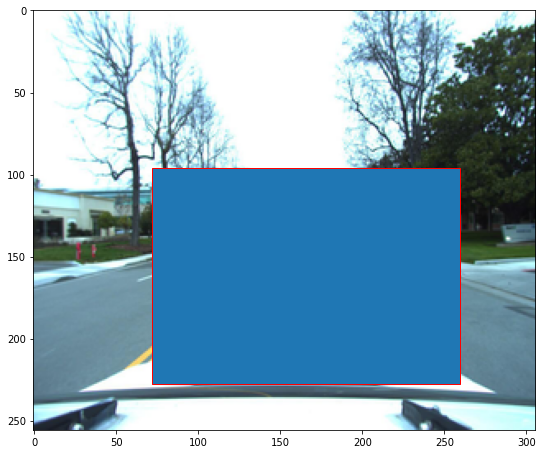

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
print(len(boxes))
ax.imshow(image)
corners = view_points(boxes[0].corners(), x, normalize=True)[:2, :]
corners1 = view_points(boxes[1].corners(), x, normalize=True)[:2, :]
print(corners)
# Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
np_corners=corners.T[:4]
np_corners1=corners1.T[:4]

#boxes[1].render(ax, view=x, normalize=True)
#ax.plot([0.13, 0.14], color="c")
#x=view_points(uboxes[0].corners(), np.eye(3), normalize=True)
rect1 = patches.Rectangle((np_corners1[1][0], np_corners1[1][1]), np_corners1[0][0]-np_corners1[1][0], -np_corners1[1][1]+np_corners1[2][1],linewidth=1,edgecolor="r")
rect2 = patches.Rectangle((np_corners[1][0], np_corners[1][1]), np_corners[0][0]-np_corners[1][0], -np_corners[1][1]+np_corners[2][1],linewidth=1,edgecolor="r")
# Add the patch to the Axes
ax.add_patch(rect2)
ax.add_patch(rect1)
corner_img_list=[]
for box in boxes:
    corners = view_points(boxes[0].corners(), x, normalize=True)[:2, :]
    corners_norm=[np_corners[1][0], np_corners[1][1], np_corners[0][0], np_corners[2][1]]
    corner_img_list.append(corners_norm)
print("here",corner_img_list)

#for i in range(len(anchors)):
rect= patches.Rectangle((anchors[136][0], anchors[136][1]), anchors[136][2], anchors[136][3],linewidth=1,edgecolor="r")
ax.add_patch(rect)

eb7e4168be13d6013ecb4faf994c5ad03dd8e209092e3de38a91d91e5155490d


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


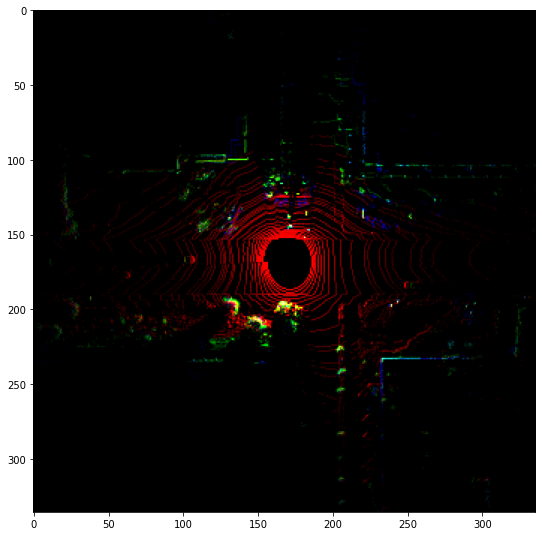

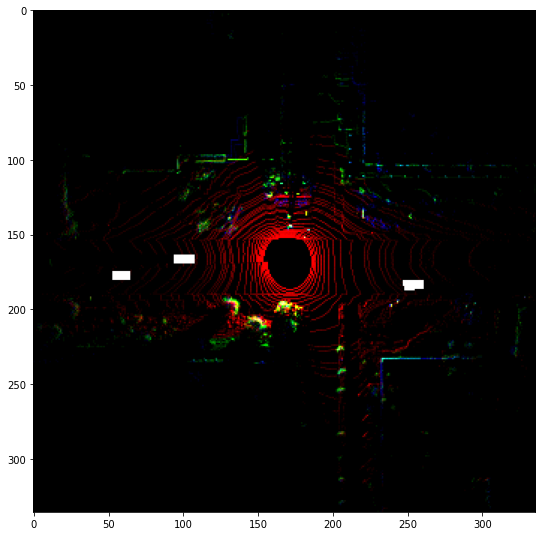

In [17]:
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility
fig, ax2 = plt.subplots(1, 1, figsize=(9, 16))
bev1 = bev_helper.normalize_voxel_intensities(bev)
bev = bev_helper.normalize_voxel_intensities(bev)
bev2=bev
ax2.imshow(bev1)
sample_lidar_token = sample["data"]["LIDAR_TOP"]
print(sample_lidar_token)
_, boxes, _ = dataset.get_sample_data(sample_lidar_token, box_vis_level=BoxVisibility.ANY, flat_vehicle_coordinates=True)
ego_p=dataset.get("ego_pose", lidar_data["ego_pose_token"])
bev_helper.move_boxes_to_car_space(bevboxes, ego_pose)
bev_helper.scale_boxes(bevboxes, 0.8)
corners=bev_helper.draw_boxes(bev, voxel_size, boxes, classes, z_offset=z_offset)
fig, ax3 = plt.subplots(1, 1, figsize=(9, 16))
ax3.imshow(bev)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[array([[248.00845048, 187.12610189],
       [247.94271628, 181.78900668],
       [260.87923511, 181.62967437],
       [260.94496931, 186.96676958]]), array([[ 53.84294722, 180.15434083],
       [ 53.8829811 , 175.51451354],
       [ 64.65258022, 175.60743701],
       [ 64.61254634, 180.24726431]]), array([[-40.26063134, 180.36228394],
       [-40.06081469, 175.50639336],
       [-28.03848889, 176.00110403],
       [-28.23830554, 180.85699461]]), array([[107.82796237, 164.7200447 ],
       [107.77686921, 169.90479296],
       [ 94.87249578, 169.77762666],
       [ 94.92358894, 164.5928784 ]]), array([[380.13684743, 161.59663253],
       [380.07898178, 166.3712819 ],
       [368.84730659, 166.23516129],
       [368.90517224, 161.46051192]])]


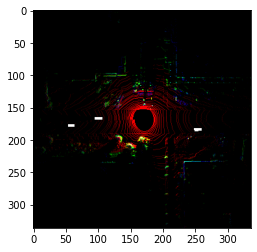

In [18]:
corners_voxel_list=[]
for box in boxes:   
    corners = box.bottom_corners()
    corners_voxel = bev_helper.car_to_voxel_coords(corners, [336,336,3], voxel_size, z_offset).transpose(1,0)
    corners_voxel = corners_voxel[:,:2] # Drop z coord
    corners_voxel_list.append(corners_voxel)
    cv2.drawContours(bev, np.int0([corners_voxel]), 0, -1)
plt.imshow(bev)
print(corners_voxel_list)

7c99fbc8c57af26cea59f5e3bb7c4d90394dd361c53d76c4226d162a12013ef5
6


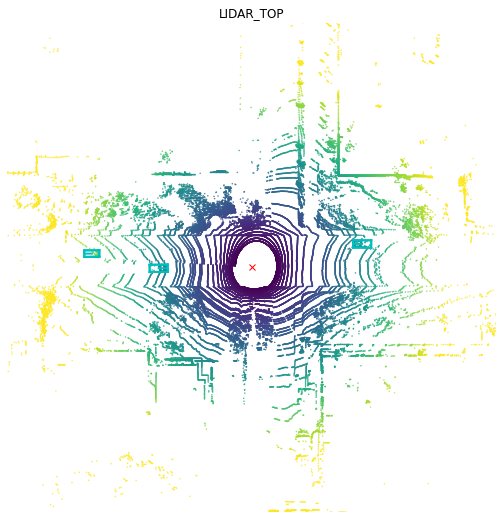

In [19]:
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, box_in_image, view_points
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
#visualize_lidar_of_sample(sample_name)
my_last_sample_token = my_scene["last_sample_token"]
sample = level5data.get("sample", my_last_sample_token)
#sample = level5data.get("sample", sample_name)
sample_lidar_token = sample["data"]["LIDAR_TOP"]
print(sample_lidar_token)
_, boxes, _ = dataset.get_sample_data(sample_lidar_token, box_vis_level=BoxVisibility.ANY, flat_vehicle_coordinates=True)
print(len(boxes))
sd_record = dataset.get("sample_data", sample_lidar_token)
# Get aggregated point cloud in lidar frame.
sample_rec = dataset.get("sample", sd_record["sample_token"])
chan = sd_record["channel"]
ref_chan = "LIDAR_TOP"
pc, times = LidarPointCloud.from_file_multisweep(
    dataset, sample_rec, chan, ref_chan, num_sweeps=1
)

# Compute transformation matrices for lidar point cloud
cs_record = dataset.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
pose_record = dataset.get("ego_pose", sd_record["ego_pose_token"])
vehicle_from_sensor = np.eye(4)
vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
vehicle_from_sensor[:3, 3] = cs_record["translation"]

ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
rot_vehicle_flat_from_vehicle = np.dot(
    Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
    Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
)

vehicle_flat_from_vehicle = np.eye(4)
vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle

# Init axes.
_, ax = plt.subplots(1, 1, figsize=(9, 9))


# Show point cloud.
points = view_points(
    pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
)

dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
colors = np.minimum(1, dists / 40 / np.sqrt(2))
ax.scatter(points[0, :], points[1, :], c=colors, s=0.2)

# Show ego vehicle.
ax.plot(0, 0, "x", color="red")

# Show boxes.
for box in boxes:
    box.render(ax, view=np.eye(4), colors=("c", "c", "c"))

# Limit visible range.
ax.set_xlim(-70, 70)
ax.set_ylim(-70, 70)
ax.axis("off")
ax.set_title(sd_record["channel"])
ax.set_aspect("equal")

In [34]:
#now build the rpn and get proposals from the anchors
k=6 #anchor number for each point
feature_map_tile = tf.keras.layers.Input(shape=(None,None,512))
convolution_3x3 = tf.keras.layers.Conv2D(
    filters=512,
    kernel_size=(3, 3),
    padding='same',
    name="3x3"
)(feature_map_tile)

output_deltas = tf.keras.layers.Conv2D(
    filters= 4 * k,
    kernel_size=(1, 1),
    activation="linear",
    kernel_initializer="uniform",
    name="deltas1"
)(convolution_3x3)

output_scores = tf.keras.layers.Conv2D(
    filters=1 * k,
    kernel_size=(1, 1),
    activation="sigmoid",
    kernel_initializer="uniform",
    name="scores1"
)(convolution_3x3)

rpn_model = tf.keras.Model(inputs=[feature_map_tile], outputs=[output_scores, output_deltas])
rpn_model.summary()
rpn_model.compile(optimizer='adam', loss={'scores1':loss_cls, 'deltas1':smoothL1})

img_feat=np.asarray(img_features)
#img_feat=tf.convert_to_tensor(x[0])
#print(img_feat.shape)
print(img_feat.shape)
res=rpn_model.predict(img_feat)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
3x3 (Conv2D)                    (None, None, None, 5 2359808     input_3[0][0]                    
__________________________________________________________________________________________________
scores1 (Conv2D)                (None, None, None, 6 3078        3x3[0][0]                        
__________________________________________________________________________________________________
deltas1 (Conv2D)                (None, None, None, 2 12312       3x3[0][0]                        
Total params: 2,375,198
Trainable params: 2,375,198
Non-trainable params: 0
___________

In [21]:
import numpy.random as npr
def bbox_transform_inv(boxes, deltas):
    if boxes.shape[0] == 0:
        return np.zeros((0, deltas.shape[1]), dtype=deltas.dtype)

    boxes = boxes.astype(deltas.dtype, copy=False)

    widths = boxes[:, 2] - boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights

    dx = deltas[:, 0::4]
    dy = deltas[:, 1::4]
    dw = deltas[:, 2::4]
    dh = deltas[:, 3::4]

    pred_ctr_x = dx * widths[:, np.newaxis] + ctr_x[:, np.newaxis]
    pred_ctr_y = dy * heights[:, np.newaxis] + ctr_y[:, np.newaxis]
    pred_w = np.exp(dw) * widths[:, np.newaxis]
    pred_h = np.exp(dh) * heights[:, np.newaxis]

    pred_boxes = np.zeros(deltas.shape, dtype=deltas.dtype)
    # x1
    pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
    # y1
    pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
    # x2
    pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
    # y2
    pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h

    return pred_boxes
def clip_boxes(boxes, im_shape):
    """
    Clip boxes to image boundaries.
    """

    # x1 >= 0
    boxes[:, 0::4] = np.maximum(np.minimum(boxes[:, 0::4], im_shape[1] - 1), 0)
    # y1 >= 0
    boxes[:, 1::4] = np.maximum(np.minimum(boxes[:, 1::4], im_shape[0] - 1), 0)
    # x2 < im_shape[1]
    boxes[:, 2::4] = np.maximum(np.minimum(boxes[:, 2::4], im_shape[1] - 1), 0)
    # y2 < im_shape[0]
    boxes[:, 3::4] = np.maximum(np.minimum(boxes[:, 3::4], im_shape[0] - 1), 0)
    return boxes
def filter_boxes(boxes, min_size):
    """Remove all boxes with any side smaller than min_size."""
    ws = boxes[:, 2] - boxes[:, 0] + 1
    hs = boxes[:, 3] - boxes[:, 1] + 1
    keep = np.where((ws >= min_size) & (hs >= min_size))[0]
    return keep
def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep
def bbox_overlaps(boxes, query_boxes):
    """
    Parameters
    ----------
    boxes: (N, 4) ndarray of float
    query_boxes: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    boxes=boxes.astype(int)
    N = boxes.shape[0]
    K = query_boxes.shape[0]

    overlaps = np.zeros((N, K), dtype=np.float)

    for k in range(K):
        box_area = ((query_boxes[k, 2] - query_boxes[k, 0] + 1) * (query_boxes[k, 3] - query_boxes[k, 1] + 1))
        for n in range(N):
            iw = (min(boxes[n, 2], query_boxes[k, 2]) - max(boxes[n, 0], query_boxes[k, 0]) + 1)
            if iw > 0:
                ih = (min(boxes[n, 3], query_boxes[k, 3]) - max(boxes[n, 1], query_boxes[k, 1]) + 1)

                if ih > 0:
                    ua = float((boxes[n, 2] - boxes[n, 0] + 1) * (boxes[n, 3] - boxes[n, 1] + 1) + box_area - iw * ih)
                    overlaps[n, k] = iw * ih / ua

    return overlaps
def unmap(data, count, inds, fill=0):
    """ Unmap a subset of item (data) back to the original set of items (of
    size count) """
    if len(data.shape) == 1:
        ret = np.empty((count, ), dtype=np.float32)
        ret.fill(fill)
        ret[inds] = data
    else:
        ret = np.empty((count, ) + data.shape[1:], dtype=np.float32)
        ret.fill(fill)
        ret[inds, :] = data
    return ret
def bbox_transform(ex_rois, gt_rois):
    ex_widths = ex_rois[:, 2] - ex_rois[:, 0] + 1.0
    ex_heights = ex_rois[:, 3] - ex_rois[:, 1] + 1.0
    ex_ctr_x = ex_rois[:, 0] + 0.5 * ex_widths
    ex_ctr_y = ex_rois[:, 1] + 0.5 * ex_heights

    gt_widths = gt_rois[:, 2] - gt_rois[:, 0] + 1.0
    gt_heights = gt_rois[:, 3] - gt_rois[:, 1] + 1.0
    gt_ctr_x = gt_rois[:, 0] + 0.5 * gt_widths
    gt_ctr_y = gt_rois[:, 1] + 0.5 * gt_heights

    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = np.log(gt_widths / ex_widths)
    targets_dh = np.log(gt_heights / ex_heights)

    targets = np.stack((targets_dx, targets_dy, targets_dw, targets_dh))

    targets = np.transpose(targets)

    return targets


scores=res[0]
scores=scores.reshape(-1,1)
deltas=res[1]
#print(all_anchors[1][:, 2], all_anchors[1])
deltas=np.reshape(deltas,(-1,4))
proposals =bbox_transform_inv(all_anchors, deltas)

proposals = clip_boxes(proposals, (img_h,img_w))
# remove small boxes, here threshold is 40 pixel
keep = filter_boxes(proposals, 40)
proposals = proposals[keep, :]
scores = scores[keep]

# apply NMS to to 6000, and then keep top 300
post_nms_topN=300
keep = py_cpu_nms(np.hstack((proposals, scores)), 0.7)
if post_nms_topN > 0:
    keep = keep[:post_nms_topN]
proposals = proposals[keep, :]
scores = scores[keep]
gt_boxes=np.asarray(corner_img_list)
overlaps = bbox_overlaps(anchors, gt_boxes)
# find the gt box with biggest overlap to each anchors,
# and the overlap ratio. result (len(anchors),)
argmax_overlaps = overlaps.argmax(axis=1)
max_overlaps = overlaps[np.arange(len(inds_inside)), argmax_overlaps]
# find the anchor with biggest overlap to each gt boxes,
# and the overlap ratio. result (len(gt_boxes),)
gt_argmax_overlaps = overlaps.argmax(axis=0)
gt_max_overlaps = overlaps[gt_argmax_overlaps,
                            np.arange(overlaps.shape[1])]

gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0]
max_overlaps=max_overlaps*10
labels = np.empty((len(inds_inside), ), dtype=np.float32)
labels.fill(-1)
labels[gt_argmax_overlaps] = 1

labels[max_overlaps >= .1] = 1
# set negative labels
labels[max_overlaps <= .09] = 0
# subsample positive labels if we have too many
#     num_fg = int(RPN_FG_FRACTION * RPN_BATCHSIZE)
fg_inds = np.where(labels == 1)[0]
num_bg = int(len(fg_inds) * 2)
bg_inds = np.where(labels == 0)[0]
if len(bg_inds) > num_bg:
    disable_inds = npr.choice(
        bg_inds, size=(len(bg_inds) - num_bg), replace=False)
    labels[disable_inds] = -1
#
batch_inds=inds_inside[labels!=-1]
batch_inds=(batch_inds / k).astype(np.int)
full_labels = unmap(labels, total_anchors, inds_inside, fill=-1)
batch_label_targets=full_labels.reshape(-1,1,1,1*k)[batch_inds]
bbox_targets = np.zeros((len(inds_inside), 4), dtype=np.float32)
bbox_targets = bbox_transform(anchors, gt_boxes[argmax_overlaps, :])
pos_anchors=all_anchors[inds_inside[labels==1]]
bbox_targets = bbox_transform(pos_anchors, gt_boxes[argmax_overlaps, :][labels==1])
bbox_targets = unmap(bbox_targets, total_anchors, inds_inside[labels==1], fill=0)
batch_bbox_targets = bbox_targets.reshape(-1,1,1,4*k)[batch_inds]
padded_fcmap=np.pad(img_feat,((0,0),(1,1),(1,1),(0,0)),mode='constant')
padded_fcmap=np.squeeze(padded_fcmap)
batch_tiles=[]
for ind in batch_inds:
    x = ind % f_map_img_w
    y = int(ind/f_map_img_w)
    fc_3x3=padded_fcmap[y:y+3,x:x+3,:]
    batch_tiles.append(fc_3x3)
#batch_tiles, batch_label_targets, batch_bbox_targets=np.asarray(batch_tiles), batch_label_targets.tolist(), batch_bbox_targets.tolist()
print(batch_inds)

[17 60 71]


In [41]:
tf.convert_to_tensor(batch_label_targets)

<tf.Tensor: shape=(3, 1, 1, 6), dtype=float32, numpy=
array([[[[ 0., -1., -1., -1., -1., -1.]]],


       [[[ 0., -1., -1., -1., -1., -1.]]],


       [[[-1., -1., -1., -1., -1.,  1.]]]], dtype=float32)>

In [35]:
rpn_model.compile(optimizer='adam', loss={'scores1':'binary_crossentropy', 'deltas1':'mse'})
rpn_model.fit(np.asarray(batch_tiles), [np.asarray(batch_label_targets),np.asarray(batch_bbox_targets)], epochs=100)

Epoch 1/100


ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 3, 3, 6) vs (None, 1, 1, 6))
